In [ ]:
import pickle
import numpy as np


In [ ]:
with open('C:\\cleaning data\\NLP\\UPDATED_NLP_COURSE\\06-Deep-Learning\\train_qa.txt','rb') as f:
    train = pickle.load(f)

In [ ]:
train

In [ ]:
with open('C:\\cleaning data\\NLP\\UPDATED_NLP_COURSE\\06-Deep-Learning\\test_qa.txt','rb') as f:
    test = pickle.load(f)

In [ ]:
len(train)

In [ ]:
len(test)

In [ ]:
train[0]

In [ ]:
' '.join(train[0][0])

In [ ]:
' '.join(train[0][1])

In [ ]:
train[0][2]

In [ ]:
all_data = train + test

In [ ]:
len(all_data)

In [ ]:
# vocabulory 
vocab = set() 

for story,ques,ans in all_data:
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(ques))

    

In [ ]:
vocab.add('yes')

In [ ]:
vocab.add('no')

In [ ]:
len(vocab)

In [ ]:
x_vocab = len(vocab) + 1


In [ ]:
# for padding-sequence 
story_length = []
ques_length = []
for x in all_data:
    
    story_length.append(len(x[0]))
    ques_length.append(len(x[1]))

In [ ]:
max(story_length)

In [ ]:
max(ques_length)

In [ ]:
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)

In [ ]:
tokenizer.word_index

In [ ]:
train_story_text = []
train_question_text = []
train_answers = []

for story,question,answer in train:
    train_story_text.append(story)
    train_question_text.append(question)

In [ ]:
train_story_seq = tokenizer.texts_to_sequences(train_story_text)

In [ ]:
def vectorize_stories(data, word_index=tokenizer.word_index, max_story_len=max(story_length),max_question_len=max(ques_length)):
    '''
    INPUT: 
    
    data: consisting of Stories,Queries,and Answers
    word_index: word index dictionary from tokenizer
    max_story_len: the length of the longest story (used for pad_sequences function)
    max_question_len: length of the longest question (used for pad_sequences function)


    OUTPUT:
    
    Vectorizes the stories,questions, and answers into padded sequences. We first loop for every story, query , and
    answer in the data. Then we convert the raw words to an word index value. Then we append each set to their appropriate
    output list. Then once we have converted the words to numbers, we pad the sequences so they are all of equal length.
    
    Returns this in the form of a tuple (X,Xq,Y) (padded based on max lengths)
    '''
    
    
    # X = STORIES
    X = []
    # Xq = QUERY/QUESTION
    Xq = []
    # Y = CORRECT ANSWER
    Y = []
    
    
    for story, query, answer in data:
        
        # Grab the word index for every word in story
        x = [word_index[word.lower()] for word in story]
        # Grab the word index for every word in query
        xq = [word_index[word.lower()] for word in query]
        
        # Grab the Answers (either Yes/No so we don't need to use list comprehension here)
        # Index 0 is reserved so we're going to use + 1
        y = np.zeros(len(word_index) + 1)
        
        # Now that y is all zeros and we know its just Yes/No , we can use numpy logic to create this assignment
        #
        y[word_index[answer]] = 1
        
        # Append each set of story,query, and answer to their respective holding lists
        X.append(x)
        Xq.append(xq)
        Y.append(y)
        
    # Finally, pad the sequences based on their max length so the RNN can be trained on uniformly long sequences.
        
    # RETURN TUPLE FOR UNPACKING
    return (pad_sequences(X, maxlen=max_story_len),pad_sequences(Xq, maxlen=max_question_len), np.array(Y))

In [ ]:
import numpy as np

In [ ]:
inputs_train, queries_train, answers_train = vectorize_stories(train)

In [ ]:
inputs_test, queries_test, answers_test = vectorize_stories(test)

In [ ]:
inputs_test

In [ ]:
queries_test

In [ ]:
from keras.models import Sequential,Model
from keras.layers.embeddings import Embedding
from keras.layers import Input,Activation,Dense,Permute,Dropout
from keras.layers import LSTM
from keras.layers import add,dot,concatenate

In [ ]:
input_sequence = Input((max(story_length),))
question = Input((max(ques_length),))

In [126]:
Encoder = Sequential()
Encoder.add(Embedding(input_dim=x_vocab,output_dim=64))
Encoder.add(Dropout(0.3))

In [130]:
Encoder_1 = Sequential()
Encoder_1.add(Embedding(input_dim=x_vocab,output_dim=max(ques_length)))
Encoder_1.add(Dropout(0.3))


In [134]:
Encoder_Q = Sequential()
Encoder_Q.add(Embedding(input_dim=x_vocab,output_dim=64,input_length=max(ques_length)))
Encoder_Q.add(Dropout(0.3))

In [135]:
input_encoded_m = Encoder(input_sequence)
input_encoded_c = Encoder_1(input_sequence)
questions_encoded = Encoder_Q(question)

In [137]:
match = dot([input_encoded_m,questions_encoded],axes=[2,2])
match = Activation('softmax')(match)

In [138]:
response = add([match, input_encoded_c])  # (samples, story_maxlen, query_maxlen)
response = Permute((2, 1))(response)

In [142]:
answer = concatenate([response, questions_encoded])

In [143]:
answer

<KerasTensor: shape=(None, 6, 220) dtype=float32 (created by layer 'concatenate_1')>

In [144]:
answer = LSTM(32)(answer)

In [146]:
answer = Dropout(0.5)(answer)
answer = Dense(x_vocab)(answer)

In [147]:
answer = Activation('softmax')(answer)

# build the final model
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [148]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 156)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 sequential (Sequential)        (None, None, 64)     2432        ['input_2[0][0]']                
                                                                                                  
 sequential_4 (Sequential)      (None, 6, 64)        2432        ['input_3[0][0]']                
                                                                                              

In [149]:
history = model.fit([inputs_train, queries_train], answers_train,batch_size=32,epochs=120,validation_data=([inputs_test, queries_test], answers_test))

Epoch 1/120
313/313 [==============================] - 17s 31ms/step - loss: 0.9967 - accuracy: 0.4942 - val_loss: 0.6984 - val_accuracy: 0.4970
Epoch 2/120
313/313 [==============================] - 9s 29ms/step - loss: 0.7212 - accuracy: 0.5036 - val_loss: 0.6933 - val_accuracy: 0.4970
Epoch 3/120
313/313 [==============================] - 9s 28ms/step - loss: 0.7019 - accuracy: 0.5060 - val_loss: 0.6946 - val_accuracy: 0.4970
Epoch 4/120
313/313 [==============================] - 8s 26ms/step - loss: 0.7001 - accuracy: 0.5051 - val_loss: 0.6932 - val_accuracy: 0.4970
Epoch 5/120
313/313 [==============================] - 8s 24ms/step - loss: 0.6982 - accuracy: 0.4932 - val_loss: 0.6933 - val_accuracy: 0.5030
Epoch 6/120
313/313 [==============================] - 7s 24ms/step - loss: 0.6971 - accuracy: 0.4954 - val_loss: 0.6932 - val_accuracy: 0.4970
Epoch 7/120
313/313 [==============================] - 8s 24ms/step - loss: 0.6977 - accuracy: 0.4950 - val_loss: 0.6951 - val_accuracy

313/313 [==============================] - 9s 27ms/step - loss: 0.3606 - accuracy: 0.8479 - val_loss: 0.3574 - val_accuracy: 0.8290
Epoch 58/120
313/313 [==============================] - 8s 27ms/step - loss: 0.3573 - accuracy: 0.8547 - val_loss: 0.3818 - val_accuracy: 0.8380
Epoch 59/120
313/313 [==============================] - 8s 27ms/step - loss: 0.3519 - accuracy: 0.8540 - val_loss: 0.3524 - val_accuracy: 0.8440
Epoch 60/120
313/313 [==============================] - 8s 27ms/step - loss: 0.3573 - accuracy: 0.8505 - val_loss: 0.3545 - val_accuracy: 0.8480
Epoch 61/120
313/313 [==============================] - 8s 27ms/step - loss: 0.3510 - accuracy: 0.8543 - val_loss: 0.3579 - val_accuracy: 0.8280
Epoch 62/120
313/313 [==============================] - 8s 27ms/step - loss: 0.3494 - accuracy: 0.8529 - val_loss: 0.3486 - val_accuracy: 0.8380
Epoch 63/120
313/313 [==============================] - 9s 27ms/step - loss: 0.3472 - accuracy: 0.8555 - val_loss: 0.3538 - val_accuracy: 0.841

313/313 [==============================] - 8s 25ms/step - loss: 0.3122 - accuracy: 0.8691 - val_loss: 0.3594 - val_accuracy: 0.8330
Epoch 114/120
313/313 [==============================] - 7s 24ms/step - loss: 0.3042 - accuracy: 0.8703 - val_loss: 0.3789 - val_accuracy: 0.8260
Epoch 115/120
313/313 [==============================] - 7s 24ms/step - loss: 0.3077 - accuracy: 0.8662 - val_loss: 0.3806 - val_accuracy: 0.8240
Epoch 116/120
313/313 [==============================] - 7s 24ms/step - loss: 0.3056 - accuracy: 0.8694 - val_loss: 0.3857 - val_accuracy: 0.8240
Epoch 117/120
313/313 [==============================] - 8s 24ms/step - loss: 0.3063 - accuracy: 0.8723 - val_loss: 0.3606 - val_accuracy: 0.8280
Epoch 118/120
313/313 [==============================] - 8s 25ms/step - loss: 0.3088 - accuracy: 0.8689 - val_loss: 0.3674 - val_accuracy: 0.8310
Epoch 119/120
313/313 [==============================] - 8s 25ms/step - loss: 0.3064 - accuracy: 0.8718 - val_loss: 0.3904 - val_accuracy:

In [150]:
filename = 'chatbot.h5'
model.save(filename)

c:\python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


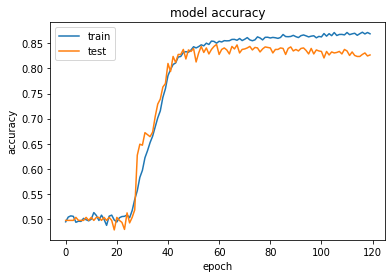

In [152]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [157]:
pred_results = model.predict(([inputs_test,queries_test]))

In [158]:
pred_results

array([[3.7692987e-12, 3.5837613e-12, 3.5735774e-12, ..., 1.0642897e-04,
        3.8488943e-12, 3.8339618e-12],
       [8.0751796e-09, 7.6960784e-09, 7.6373086e-09, ..., 7.1829341e-02,
        8.0005638e-09, 7.9982607e-09],
       [3.7635478e-10, 3.5983125e-10, 3.5757280e-10, ..., 8.6076266e-01,
        3.6799783e-10, 3.5825207e-10],
       ...,
       [3.2362419e-09, 3.0437071e-09, 3.0760747e-09, ..., 2.9869841e-02,
        3.2461331e-09, 3.2262824e-09],
       [5.5678957e-15, 5.1098169e-15, 5.2312323e-15, ..., 9.9667442e-01,
        5.2362433e-15, 5.0851606e-15],
       [1.4443546e-12, 1.3028216e-12, 1.3013786e-12, ..., 9.9894828e-01,
        1.2617411e-12, 1.3096804e-12]], dtype=float32)

In [160]:
story =' '.join(word for word in test[0][0])
print(story)

Mary got the milk there . John moved to the bedroom .


In [162]:
' '.join(word for word in test[0][1])

'Is John in the kitchen ?'

In [163]:
test[0][2]

'no'

In [164]:
val_max = np.argmax(pred_results[0])
for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

Predicted answer is:  no
Probability of certainty was:  0.99989355
